# CS 269Q: Final Project - QAOA on MIS
***
## Part 1: Using Classical Optimizer

__Note:__ Part 2: Using Grid Search is documented on another notebook.

__GOAL:__ Generate random MIS instances for simulation on the QVM and benchmark against various noise models.

In [1]:
from pyquil import Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import H, I, RX, CNOT, RESET
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum
from scipy.optimize import minimize

import operator
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

From arXiv:1808.10816v1 [quant-ph], the variational wavefunctionn is prepared using the following hamiltonians:

$$H_p = \sum_{v \in V} -\Delta n_v + \sum_{(v,w) \in E} U n_v n_w$$

$$H_Q = \sum_{v \in V} \Omega \sigma_v^x + \sum_{(v,w) \in E} U n_v n_w$$

where $n_v = |1>_v<1| = \frac{I - \sigma_z}{2}$

__Generating Graphs:__ For the purposes of this project, I will be generating the random graphs in Wolfram Mathematica using the command `g = RandomGraph[{nodes, edges}]` and then retrieving the edge representation using `EdgeList[g]` where g is the graph I generated. I chose Mathematica, as it can be used to calculate the Maximum Independent Set of the graph using the command `Sort[FindIndependentVertexSet[g, Length /@ FindIndependentVertexSet[g], All]]` and thus verify the solution found via QAOA.

## Section 1: Running on the QVM

In [2]:
def elist_from_math(string: str) -> str:
    '''
    Formats the edge list provided by Mathematica.
    '''
    string = string.replace(',','), (')
    string = string.replace(' <->',',')
    return eval('(' + string + ')')

In [3]:
def get_hamil(num_nodes: int, edge_list: List[Tuple[int, int]], delta: float, 
              U: float, omega: float) -> 'PauliSum, PauliSum':
    '''
    For a given graph, and values of hyperparameters, returns the cost and driver Hamiltonians.
    '''
    # Mathematica labels nodes starting at 1 but we label qubits starting at 0
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

### Noisless Implementation

In [4]:
def mis_ansatz(betas: List[float], gammas: List[float]) -> Program:
    '''
    Returns the program to create the MIS ansatz.
    '''
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return pq

In [5]:
def mis_cost(params: List[float]) -> float:
    '''
    Returns the value of the cost function given params.
    '''
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    pq = mis_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost)

In [14]:
def run_qaoa_mis(p: int, params: List[float], correct_state: str) -> 'dict key-value pair, float':
    '''
    Returns the mpost probable state and its probability, and the probability of the correct state.
    '''
    # Scaling max iterating for a given p to make a the comparison more standard
    # iters = 50*p
    # print("p value:", p, "and number of iters:", iters)
    # result = minimize(mis_cost, x0 = params, method='Nelder-Mead', options={'disp': True, 'maxiter': iters})
    
    # unlimited iterations
    result = minimize(mis_cost, x0 = params, method='Nelder-Mead', options={'disp': True})
    
    half = int(len(result['x'])/2)
    pq = mis_ansatz(result['x'][:half],result['x'][half:])
    
    wf_sim = WavefunctionSimulator()
    wavefunction = wf_sim.wavefunction(pq)
    prob_dict = wavefunction.get_outcome_probs() 
    sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
    return sorted_dict[len(prob_dict)-1], prob_dict.get(correct_state)

In [7]:
def run_p_range(max_p: int, correct_state: str) -> 'List[int], List[float], List[str]':
    '''
    Runs QAOA on MIS for multiple p values from 1 to max_p.
    '''
    p_vals = []
    prob_vals = []
    colors = []
    for p in range(1, max_p + 1):
        p_vals.append(p)
        params = [0.5] * 2 * p
        result, prob_correct = run_qaoa_mis(p, params, correct)
        if (result[0] == correct):
            print("GOOD p value:", p, "with State:", result[0])        
            prob_vals.append(result[1])
            colors.append('g')
        else:
            print("BAD p value:", p, "with State:", result[0])
            prob_vals.append(prob_correct)
            colors.append('r')
    return p_vals, prob_vals, colors

#### Running QAOA on MIS

1. First we must get the edge list from Mathematica, and set the hyperparameters $\Delta, U$ and $\omega$. Also get the cost and the driver hamiltonians. 

In [8]:
# elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
#         (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
# string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8' # graph2 
string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5' # graph3

elist = elist_from_math(string)

# SET THESE PARAMS
num_nodes = 5 # update
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

2. Ensure that you set your parameters correctly by running QAOA for p = 2. Currently p = 1 does not result in the correct answer.

__Note:__ The qubits are labelled from the right.

In [9]:
%%time

# check that we get the expected result
# correct = '1011010000'
# correct = '10110110'
correct = '10100'

result, prob_correct = run_qaoa_mis(2, [0.5, 0.5, 0.5, 0.5], correct)
print(result)
print(prob_correct)

p value: 2 and number of iters: 100
('10100', 0.10241357111186623)
0.10241357111186623
CPU times: user 2.35 s, sys: 56.2 ms, total: 2.41 s
Wall time: 3.97 s


3. Set the maximum p value you want to run for, and run the algorithm!

In [27]:
%%time

# SET THIS VALUE
p_max = 10

p_vals, prob_vals, colors = run_p_range(p_max, correct)

p value: 1 and number of iters: 50
BAD p value: 1 with State: 00000
p value: 2 and number of iters: 100
GOOD p value: 2 with State: 10100
p value: 3 and number of iters: 150
GOOD p value: 3 with State: 10100
p value: 4 and number of iters: 200
GOOD p value: 4 with State: 10100
p value: 5 and number of iters: 250
GOOD p value: 5 with State: 10100
p value: 6 and number of iters: 300
GOOD p value: 6 with State: 10100
p value: 7 and number of iters: 350
GOOD p value: 7 with State: 10100
p value: 8 and number of iters: 400
GOOD p value: 8 with State: 10100
p value: 9 and number of iters: 450
GOOD p value: 9 with State: 10100
p value: 10 and number of iters: 500
GOOD p value: 10 with State: 10100
CPU times: user 2min 7s, sys: 1.25 s, total: 2min 9s
Wall time: 3min 24s


4. To see how QAOA performed on your graph, plot the results. Red color means that the most probable state was not the correct state, while green means that it was.

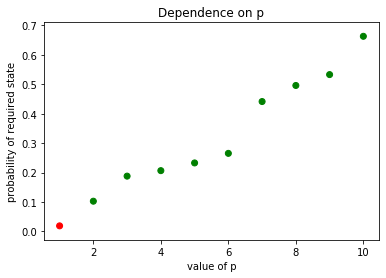

In [28]:
plt.scatter(p_vals, prob_vals, color = colors) 
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of required state")
# plt.savefig("pgraph3.png")
plt.show()

In [29]:
prob_vals

[0.018551935726479268,
 0.10241357111186623,
 0.18766430160452127,
 0.20634872203745952,
 0.23254463830689542,
 0.265105699991763,
 0.44133566005393843,
 0.4959777926613009,
 0.5329919262665037,
 0.6631958811106692]

#### Plotting all values

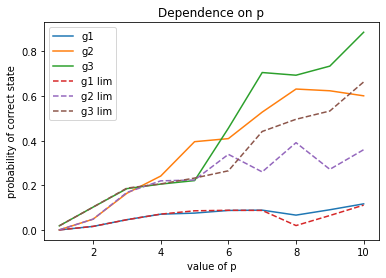

In [36]:
paxis = list(range(1,11))
plt.plot(paxis, [0.0002584088825309589, 0.016013513616306287, 0.04617072571470806, 0.07077191741821537, 0.07560195740556094,
 0.08751310563042256, 0.08883531569983363, 0.06653509811964456, 0.09057367498538071, 0.11702668124351008], label = 'g1') 
plt.plot(paxis, [0.0005317994423599302, 0.04844621167737637, 0.16448419711373685, 0.24162292345998884, 0.3955198436659364,
  0.409267066296394, 0.5279943164193701, 0.6313983067454861, 0.623606445096216, 0.6009971137120277], label = 'g2')
plt.plot(paxis, [0.018551935708694726, 0.10241589381176734, 0.1852167182088925, 0.20558281325232938, 0.2212128411269047,
 0.4559834830957632, 0.7053359374171075, 0.6933577935722443, 0.7340931703510583, 0.8858375563026535], label = 'g3')
plt.plot(paxis, [0.00025840888373638513, 0.016007294155534146, 0.046026503812618504, 0.07110633993353646, 0.08592458108855694,
 0.08822873035040116, 0.08756065585648515, 0.019802383927298148, 0.06475600039004104, 0.11134665527605557], '--', label = 'g1 lim')
plt.plot(paxis, [0.0005317994423599302, 0.04846068694867068, 0.16833435898860002, 0.22010295717138745, 0.22399681825545284,
 0.338817328756781, 0.2601803984751079, 0.39111098722327375, 0.2717148731462373, 0.3596595186476516], '--', label = 'g2 lim')
plt.plot(paxis, [0.018551935726479268, 0.10241357111186623, 0.18766430160452127, 0.20634872203745952, 0.23254463830689542,
 0.265105699991763, 0.44133566005393843, 0.4959777926613009, 0.5329919262665037, 0.6631958811106692], '--', label = 'g3 lim')
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of correct state")
plt.legend()
# plt.savefig("p_depth_lim.png")
plt.show()

__I can do 5 types of analyses:__
1. Let Nealder-Mead run forever and forever
2. Stop at 100 or certain number of iters that scales with p
3. Grid search for params
4. Grid search with width decreasing - takes too long
5. Adding noise

### Implementation with Noise

To add noise to our program using the PyQuil noise module, we first need to convert our program to the form where it uses the module's specific gate set. To do this, we will be using quilc.

In [55]:
from pyquil.api import get_qc

def make_native(program):
    print(program)
    qc_name = str(num_nodes) + "q-qvm"
    qc = get_qc(qc_name)
    ep = qc.compile(program)
    return ep

In [59]:
pq1 = make_native(Program(I(0)))
pq1 = noise.add_decoherence_noise(pq1)

I 0



KeyError: 0

In [47]:
from pyquil import noise

def mis_ansatz(betas: List[float], gammas: List[float]) -> Program:
    '''
    Returns the program to create the MIS ansatz.
    '''
    print("Adding noise")
    
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    pq = make_native(pq)
    # pq = noise.add_decoherence_noise(pq, T1=3e-05, T2=3e-05, gate_time_1q=5e-08, gate_time_2q=1.5e-07, ro_fidelity=0.95)
    return pq

In [49]:
pq

'RESET\nRZ(-2.5707963267948966) 1\nRX(pi/2) 1\nCZ 1 0\nRX(-pi/2) 1\nRZ(0.375) 1\nRX(pi/2) 1\nCZ 1 0\nRZ(-2.5707963267948966) 3\nRX(pi/2) 3\nRZ(pi/2) 3\nRX(-pi/2) 1\nRZ(pi/2) 1\nRZ(-2.1957963267948966) 2\nRX(pi/2) 2\nCZ 2 0\nRX(-pi/2) 2\nRZ(0.375) 2\nRX(pi/2) 2\nCZ 2 0\nCZ 2 1\nRX(-pi/2) 2\nRZ(0.375) 2\nRX(pi/2) 2\nCZ 2 1\nCZ 3 0\nRZ(-pi/2) 3\nRX(-pi/2) 3\nRZ(0.375) 3\nRX(pi/2) 3\nCZ 3 0\nCZ 3 1\nRX(-pi/2) 3\nRZ(0.375) 3\nRX(pi/2) 3\nCZ 3 1\nRZ(-2.1957963267948966) 4\nRX(pi/2) 4\nCZ 4 0\nRX(-pi/2) 4\nRZ(0.375) 4\nRX(pi/2) 4\nCZ 4 0\nRX(-pi/2) 2\nCZ 3 2\nRX(-pi/2) 3\nRZ(0.375) 3\nRX(pi/2) 3\nCZ 3 2\nCZ 4 1\nRX(-pi/2) 4\nRZ(0.375) 4\nRX(pi/2) 4\nCZ 4 1\nRZ(-0.8497873829844081) 0\nRX(pi/2) 0\nRZ(1.6523681893351636) 0\nRX(-pi/2) 0\nRZ(-1.5707963267948968) 1\nRX(pi/2) 1\nRZ(2.6415926535897927) 1\nRX(-pi/2) 1\nCZ 0 1\nRZ(-2.064654832850452) 0\nRX(pi/2) 0\nRZ(0.375) 0\nRX(-pi/2) 0\nCZ 0 1\nRX(1.5707963267948963) 3\nRX(pi/2) 4\nRZ(0.5605543102888061) 4\nRX(-pi/2) 4\nCZ 4 3\nRX(pi/2) 4\nRZ(0.375

In [22]:
# elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
#         (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
# string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8' # graph2 
string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5' # graph3

elist = elist_from_math(string)

# SET THESE PARAMS
num_nodes = 5 # update
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

In [25]:
%%time

# check that we get the expected result
# correct = '1011010000'
# correct = '10110110'
correct = '10100'

result, prob_correct = run_qaoa_mis(2, [0.5, 0.5, 0.5, 0.5], correct)
print(result)
print(prob_correct)

Adding noise
RESET
X 0
PHASE(-0.4375) 0
X 0
PHASE(-0.4375) 0
RZ(-1.0) 0
RZ(-1.0) 1
RZ(-0.625) 2
RZ(-1.0) 3
RZ(-0.625) 4
CNOT 0 1
RZ(0.375) 1
CNOT 0 1
CNOT 0 2
RZ(0.375) 2
CNOT 0 2
CNOT 0 3
RZ(0.375) 3
CNOT 0 3
CNOT 0 4
RZ(0.375) 4
CNOT 0 4
CNOT 1 2
RZ(0.375) 2
CNOT 1 2
CNOT 1 3
RZ(0.375) 3
CNOT 1 3
CNOT 1 4
RZ(0.375) 4
CNOT 1 4
CNOT 2 3
RZ(0.375) 3
CNOT 2 3
CNOT 3 4
RZ(0.375) 4
CNOT 3 4
H 0
RZ(0.5) 0
H 0
H 1
RZ(0.5) 1
H 1
H 2
RZ(0.5) 2
H 2
H 3
RZ(0.5) 3
H 3
H 4
RZ(0.5) 4
H 4
X 0
PHASE(-1.6875) 0
X 0
PHASE(-1.6875) 0
RZ(-1.5) 1
RZ(-1.5) 0
CNOT 0 1
RZ(0.375) 1
CNOT 0 1
RZ(-1.125) 2
CNOT 0 2
RZ(0.375) 2
CNOT 0 2
RZ(-1.5) 3
CNOT 0 3
RZ(0.375) 3
CNOT 0 3
RZ(-1.125) 4
CNOT 0 4
RZ(0.375) 4
CNOT 0 4
CNOT 1 2
RZ(0.375) 2
CNOT 1 2
CNOT 1 3
RZ(0.375) 3
CNOT 1 3
CNOT 1 4
RZ(0.375) 4
CNOT 1 4
CNOT 2 3
RZ(0.375) 3
CNOT 2 3
CNOT 3 4
RZ(0.375) 4
CNOT 3 4
X 0
PHASE(-0.4375) 0
X 0
PHASE(-0.4375) 0
RZ(-1.0) 0
RZ(-1.0) 1
RZ(-0.625) 2
RZ(-1.0) 3
RZ(-0.625) 4
CNOT 0 1
RZ(0.375) 1
CNOT 0 1
CNOT 0 2
RZ(0.375)

RuntimeError: Error encountered while parsing the quil program at line 1 and column 2
Received an '<EOF>' but was expecting one of [ INT, '(' ]

In [ ]:
%%time

# SET THIS VALUE
p_max = 10

p_vals, prob_vals, colors = run_p_range(p_max, correct)

In [ ]:
plt.scatter(p_vals, prob_vals, color = colors) 
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of required state")
# plt.savefig("pgraph3.png")
plt.show()

In [ ]:
prob_vals

## Section 2: Running on the QPU

In [2]:
from pyquil.gates import MEASURE, X

In [3]:
from pyquil import get_qc
from pyquil.api._devices import list_devices, list_lattices

In [4]:
def get_hamil(nodes: List[int], edge_list: List[Tuple[int, int]], delta: float, 
              U: float, omega: float) -> 'PauliSum, PauliSum':
    '''
    For a given graph, and values of hyperparameters, returns the cost and driver Hamiltonians.
    '''
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

In [5]:
def mis_qpu_ansatz(betas: List[float], gammas: List[float], num_nodes) -> Program:
    '''
    Returns the program to create the MIS ansatz.
    '''    
    qubits = list(range(0,num_nodes))
    
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    ro = pq.declare('ro', 'BIT', len(qubits))
    pq.inst([MEASURE(qubit, ro[idx]) for idx, qubit in enumerate(qubits)])
    pq = make_native(pq)
    return pq

In [6]:
device_names = list_devices()  # Available devices are subject to change.
lattice_names = list(list_lattices().keys())  # Available lattices are subject to change.
print(f"Available devices: {device_names}.\n")
print(f"Available lattices: {lattice_names}.")

Available devices: ['Aspen-4'].

Available lattices: ['Aspen-4-2Q-A', 'Aspen-4-3Q-A', 'Aspen-4-4Q-A', 'Aspen-4-5Q-A', 'Aspen-4-6Q-A', 'Aspen-4-7Q-A', 'Aspen-4-8Q-A', 'Aspen-4-9Q-A', 'Aspen-4-10Q-A', 'Aspen-4-15Q-A', 'Aspen-4-11Q-A', 'Aspen-4-12Q-A', 'Aspen-4-13Q-A', 'Aspen-4-14Q-B', 'Aspen-4-16Q-A'].


In [10]:
qpu = get_qc('Aspen-4-8Q-A')

RuntimeError: It looks like you've tried to run a program against a QPU but do
 not currently have a reservation on one. To reserve time on Rigetti
 QPUs, use the command line interface, qcs, which comes pre-installed
 in your QMI. From within your QMI, type:

    qcs reserve --lattice <lattice-name>

For more information, please see the docs at
https://www.rigetti.com/qcs/docs/reservations or reach out to Rigetti
support at support@rigetti.com.

In [8]:
nodes = [0,1,2,7,15]
elist = [(0,7),(0,1),(1,2)]

# SET THESE PARAMS
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(nodes, elist, delta, U, omega)

In [70]:
# mis_program = mis_qpu_ansatz([0.5], [0.5])

mis_program = Program(RESET(), X(1))
ro = mis_program.declare('ro', 'BIT', 1)
mis_program.inst(MEASURE(1, 0))

mis_program.wrap_in_numshots_loop(10_000)
binary = qpu.compile(mis_program)

NameError: name 'qpu' is not defined

In [ ]:
results = qpu.run(binary)

In [ ]:
counts = {bit_tuple: 0 for bit_tuple in itertools.product((0, 1), repeat=3)}
for shot_result in results:
    bit_tuple = tuple(shot_result)
    counts[bit_tuple] += 1  
print(f'Measurement results:')
for bit_tuple, count in counts.items():
    print(bit_tuple, count)